In [1]:
#modulos
import numpy as np
from sklearn.cluster import KMeans 
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import fclusterdata, ward
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import time
import sys
import csv
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d
import phate
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn import metrics
import hdbscan
from umap import umap_
from sklearn.manifold import SpectralEmbedding
import pandas as pd
import os

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Motivation

I am interested in clustering cells from SCIseq data sets into clusters that represent the individual that these cells derived from. To do this I am clustering based on the probability of P1 homozygosity at each SNP. 


https://scikit-learn.org/stable/modules/clustering.html#

## K-means

I want to test a k means approach and in particular I want to see if it would reasonable to use an AIC to determine optimal cluster size and how it coincides with the ground truth.

In [2]:
p = np.load('prediction_SPARSE_size_distorted.npy')

In [2]:
#Cluster the boys

start = time.time()


#kmeans = KMeans(n_clusters=971, n_jobs=2).fit(p)



end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:00.00


In [25]:
#model = GaussianMixture(n_components=260, init_params='kmeans')
#model.fit(p)
#print(model.aic(p))

distortion = sum(np.min(cdist(p, kmeans.cluster_centers_, 'euclidean'), axis=1)) / p.shape[0]

This will calculate the distortion value that when plotted many times should tell us the optimal K size by examining the elbow of the curve

In [27]:
elbow = []
for k in range(255, 265):
    kmeans = KMeans(n_clusters=k, n_init=1, max_iter=30).fit(p)
    distortion = sum(np.min(cdist(p, kmeans.cluster_centers_, 'euclidean'), axis=1)) / p.shape[0]
    elbow.append(distortion)


255
256
257
258
259
260
261
262
263
264


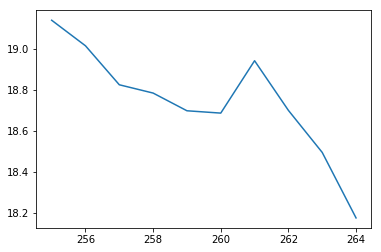

In [31]:
ks = [k for k in range(255, 265)]
sns.lineplot(ks, elbow)

## Hierarchical

Distane based agglomerative method that is much faster than k-means, but is more dificult to intuitively understand.

In [25]:
start = time.time()


hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=25, affinity='euclidean', linkage='ward')
hierarchy_clusters = hierachy.fit_predict(p)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:09.14


In [26]:
start = time.time()

hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=1000, affinity='manhattan', linkage='complete')
man_clusters = hierachy.fit_predict(p)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:09.39


We can use sklearn to perform hierarchical clustering using a k clusters parameter so we can permute the k parameter space. So let's try some implementations and time them.

In [27]:
hierachy = AgglomerativeClustering(n_clusters=971, affinity='euclidean', linkage='ward')

start = time.time()
k_hierarchy = hierachy.fit_predict(p)

end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:09.35


## Spectral clustering

This algorithm is similar to k-means but used SVD to reduce the dimensionality of the problem. Really it functions as a graph and chops up nodes by their proximity in the distance matrix. Should perform faster than k-means.

In [56]:
def graph():
    aff_matrix = np.zeros(shape=(len(p[:,0]),len(p[:,0])))
    
    for xi in range(len(p[:,0])):
        for yi in range(len(p[:,0])):
            
            aff_matrix[xi][yi] = np.sum(abs(p[xi] - p[yi]))
            
    return aff_matrix

I think in reality I actually computed the affinity matrix incorrectly above. I think Sklearn can compute it for me.

Let's instead compute a KNN graph and see if we can make this work.

In [66]:
A = kneighbors_graph(p, 2)

In [72]:
sc = SpectralClustering(n_clusters=1000,)

In [75]:
 aff = sc.fit(p).affinity_matrix_

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: inv

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: RuntimeWarning: overflow encountered in square
  inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: RuntimeWarning: overflow encountered in square
  inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: overflow encountered in square
  max_iter=max_iter, verbose=verbose)
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:442: RuntimeWarning: invalid value encountered in subtract
  max_iter=max_iter, verbose=verbose)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: RuntimeWarning: overflow encountered in square
  inertia = np.sum((X -

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:2

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:274: RuntimeWarning: invalid value encountered in add
  distances += XX
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:444: RuntimeWarning: overflow encountered in square
  inertia = np.sum((X - centers[labels]) ** 2, dtype=np.float64)
/home/iskander/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (1000). Possibly due to duplicate points in X.
  n_init=n_init)


In [76]:
print(aff)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## DBSCAN

In [7]:
start = time.time()
db = DBSCAN(eps=25, min_samples=2).fit(p)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:29.68


In [8]:
replacement = np.asarray([x for x in range(max(db.labels_)+1, len(np.where(db.labels_ == -1)[0])+ max(db.labels_)+1)])

db.labels_[np.where(db.labels_==-1)] = replacement

In [9]:
start = time.time()
db_1 = DBSCAN(eps=25, min_samples=1).fit(p)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:37.32


## OPTICS

In [31]:
start = time.time()
opts = OPTICS(min_cluster_size=1).fit(p)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:04:25.39


## HDBSCAN

In [8]:
hd = hdbscan.HDBSCAN(min_samples=1, min_cluster_size=2).fit(p).labels_

I don't really understand the parameters being chosen in HDBSCAN to be honest with you so I'm not going.

# Performance of the clustering algorithm

In [442]:
def readout_clust(cluster_pred, model='default'):
    #### Get all cluster predictions and cells into a table:
    all_clusters = {}
    for cell in range(len(cluster_pred)):
        if cluster_pred[cell] not in all_clusters.keys():
            all_clusters[cluster_pred[cell]] = [cell]
        else:
            all_clusters[cluster_pred[cell]].append(cell)
            
    mergeable_clusters = [np.asarray(all_clusters[mc])+1 for mc in all_clusters.keys() if len(all_clusters[mc]) > 1]
    
    return mergeable_clusters
    #with open('{0}.cluster.calls'.format(model)) as myCalls:
    #    for cluster_IDs in mergeable_clusters:
    #        str_inds = [str(indiv + 1) for indiv in cluster_IDs]
    #        sysout = ', '.join(str_inds)

            
def checkClust(mergeable_clusters,tsv = '/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', model='default'):
    cluster_calls = []
    
    for field in mergeable_clusters:
        cluster = tuple(sorted(field))
        cluster_calls.append(cluster)
        
    
    cluster_calls = set(cluster_calls)
    cluster_check = {}
    with open(tsv, 'r') as Check:
        reader = csv.reader(Check, delimiter='\t')
        
        index = 1
        for field in reader:
            if int(field[0]) not in cluster_check.keys():
                cluster_check[int(field[0])] = []
            else:
                cluster_check[int(field[0])].append(index)
            
            index += 1
        Check.close()
    true_clusters = []
    for n in range(1, 972):#End of range is the number of unique individuals in the sample from the crossover.tsv
        if len(cluster_check[n]) == 0:
             pass
        else:
            cluster = tuple(sorted([n]+cluster_check[n]))
            true_clusters.append(cluster)
    true_clusters = set(true_clusters)

    #print(true_clusters - cluster_calls)
    
    correct = true_clusters & cluster_calls
    missing = true_clusters - correct
    wrong = cluster_calls - correct
    
    
       #Check how badly we were off on the missing/wrong clusters:
    
    #missing = sorted(list(missing))
    #wrong = sorted(list(wrong))
    
    missed_elements = 0
    over_cluster = 0
    completely_wrong = 0
    missing_matrix = []
    
    
    for wrong_set in wrong:
        completely_missing = [0 for i in range(len(missing))] #This is a strange and convoluted way to check if any of the items are ccomplete missing
        #But it functions by crreating a matrix of 1,0s and any columns where  there are only 1s will be missing
        check = 0
        #Iterate through the wrong clusters
        missing_index = 0
        for missing_set in missing:
            #Check which wrong clusters intersect with the missing clusters
            intersected = set(wrong_set) & set(missing_set)
            
            
            missing_elements =  set(missing_set)- set(wrong_set)
            incorrect_elements = set(wrong_set) - set(missing_set)
            
            if len(intersected) >= 1:
                check += 1
                #print(missing_set)
                #print(intersected)
                if len(missing_elements) > 0:
                    missed_elements += 1
                if len(incorrect_elements) > 0:
                    over_cluster += 1
            else:
                completely_missing[missing_index] += 1
            missing_index += 1
        
        missing_matrix.append(completely_missing)
        
        if check == 0:
            completely_wrong += 1
    missing_matrix = np.asarray(missing_matrix)
    #calculate how many are fully missing by taking the sum of the columns and seeing if it is equal to the number of wrong clusters
    unmerged = len(np.where(np.sum(missing_matrix, axis=0) == len(wrong))[0])
    ele_unclustered = [list(missing)[i] for i in np.where(np.sum(missing_matrix, axis=0) == len(wrong))[0]]
    print(ele_unclustered)
    
    ###Plot###
    with sns.axes_style('whitegrid'):
        sns.barplot(y=[len(true_clusters), len(cluster_calls),len(correct), len(missing), len(wrong)],
                x = ['True\n({0})'.format(len(true_clusters)),'Predictions\n({0})'.format(len(cluster_calls)),'Correct\n({0})'.format(len(correct)), 'Missing\nclusters ({0})'.format(len(missing)), 'Wrong\nclusters ({0})'.format(len(wrong))])
        plt.ylabel('Number of clusters')
        plt.title('{0} benchmark'.format(model))

        #plt.savefig('ward_d25_benchmark.png', dpi=300)
        plt.show()
        plt.close()
    with sns.axes_style('whitegrid'):
        sns.barplot(y=[missed_elements, over_cluster, completely_wrong, unmerged], x=['Element(s) missing', 'Over clustering', 'Completely wrong', 'Unmerged/missing'])
        plt.ylabel('Number of Errors')
        plt.title('Sources of error')
        #plt.savefig('ward_d25_errors.png', dpi=300)
        plt.show()
        plt.close()

        


## HDBSCAN

[]


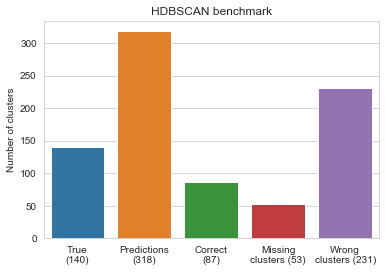

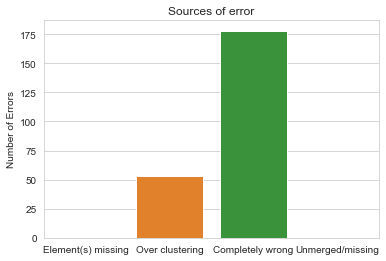

In [10]:
checkClust(mergeable_clusters=readout_clust(hd), model='HDBSCAN')

## OPTICS

[]


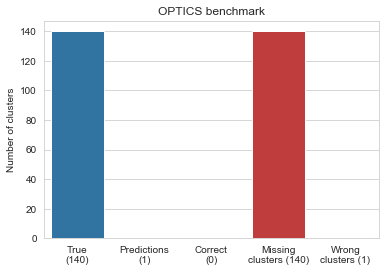

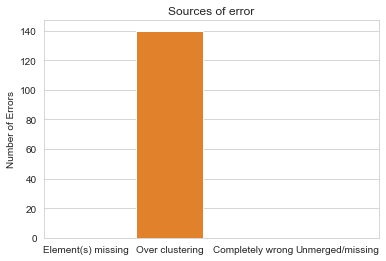

In [32]:
checkClust(mergeable_clusters=readout_clust(opts.labels_), model='OPTICS')

## DBSCAN

[(777, 1130), (52, 1065), (359, 1055)]


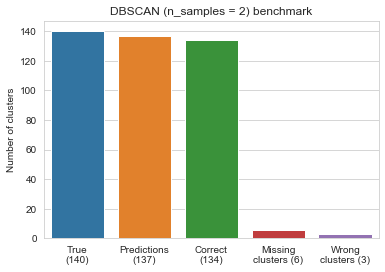

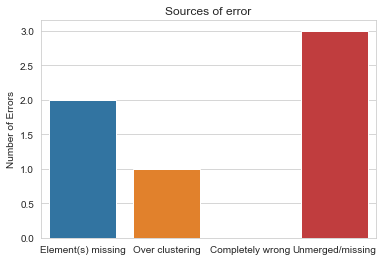

In [68]:
checkClust(mergeable_clusters=readout_clust(db.labels_), model='DBSCAN (n_samples = 2)')

In [32]:
cluster_metrics(db_1.labels_, p) #DBSCAN

/home/iskander/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(0.9777702077803462, 0.1945324305585539)

[(777, 1130), (52, 1065), (359, 1055)]


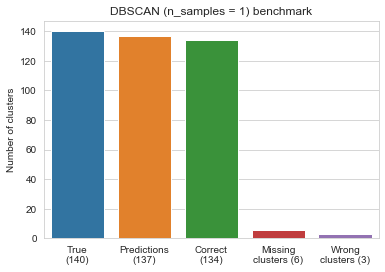

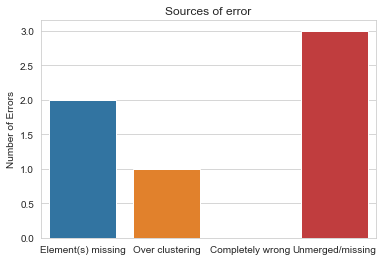

In [71]:
checkClust(mergeable_clusters=readout_clust(db_1.labels_), model='DBSCAN (n_samples = 1)')

[(836, 1133), (349, 983), (25, 1116), (567, 1113), (900, 1117), (265, 1012), (266, 1031), (255, 1107), (874, 1103), (350, 1002), (367, 1096), (464, 1099), (514, 1001), (446, 1109), (603, 1112), (167, 973), (423, 990), (187, 996), (304, 1049), (875, 1092), (920, 1115), (138, 1126), (139, 1144), (497, 991), (166, 1140), (26, 1062)]


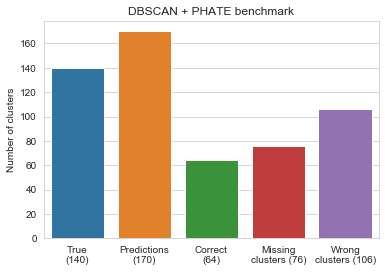

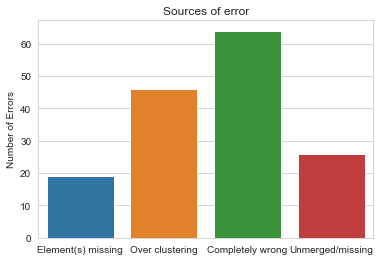

In [86]:
checkClust(mergeable_clusters=readout_clust(db_phate.labels_), model='DBSCAN + PHATE')

### Hierarchical clustering on distance cutoff 


In [29]:
cluster_metrics(hierarchy_clusters) #Agglomerative clustering d=25 Ward criterion

(0.9705117087977173, 0.9495170922097985)

[(777, 1130), (52, 1065), (359, 1055)]


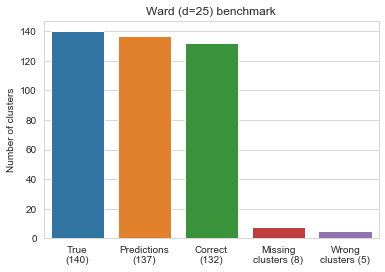

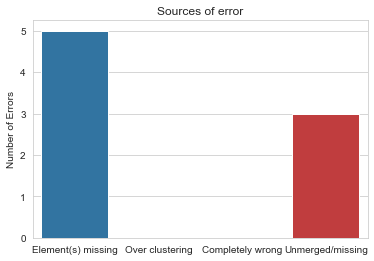

In [63]:
checkClust(mergeable_clusters=readout_clust(hierarchy_clusters), model='Ward (d=25)')

### Hierarchical clustering K clusters

[(777, 1130)]


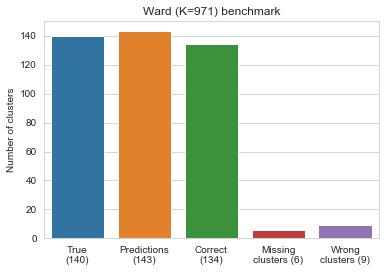

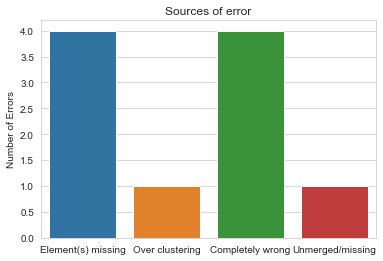

In [69]:
checkClust(mergeable_clusters=readout_clust(k_hierarchy), model='Ward K-clusters')

## Complete linkage manhattan distance 

[(875, 1092), (138, 1126), (777, 1130), (213, 1033), (350, 1002), (52, 1065), (359, 1055), (260, 1044), (107, 1100)]


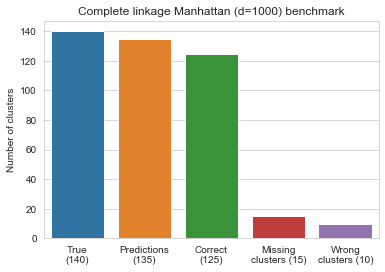

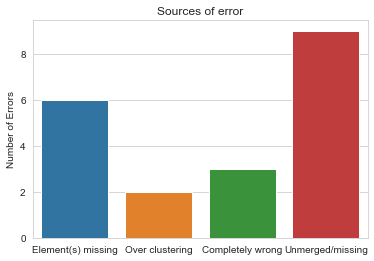

In [124]:
checkClust(mergeable_clusters=readout_clust(man_clusters), model='Complete linkage Manhattan (d=1000)')

## K-means 

[(836, 1133), (349, 983), (579, 974), (25, 1116), (567, 1113), (900, 1117), (265, 1012), (266, 1031), (255, 1107), (874, 1103), (777, 1130), (350, 1002), (367, 1096), (464, 1099), (514, 1001), (446, 1109), (167, 973), (423, 990), (187, 996), (304, 1049), (875, 1092), (920, 1115), (138, 1126), (968, 1119), (497, 991), (166, 1140), (139, 1144)]


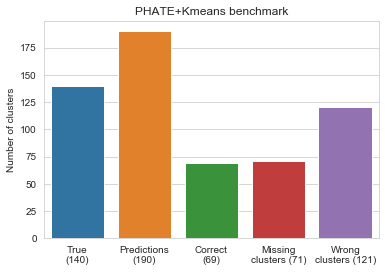

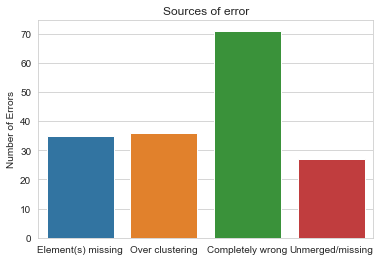

In [98]:
checkClust(mergeable_clusters=readout_clust(kmeans), model='PHATE+Kmeans')

[(600, 1063), (89, 1076), (567, 1113), (116, 1142), (260, 1044), (875, 1092)]


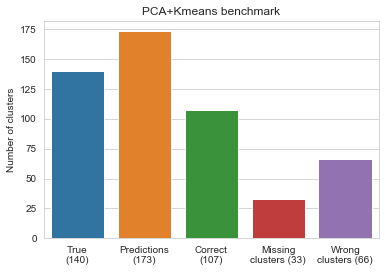

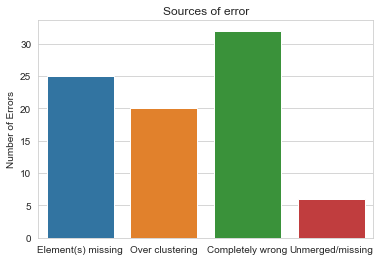

In [117]:
checkClust(mergeable_clusters=readout_clust(pca_kmeans), model='PCA+Kmeans')

## Spectral Clustering

[]


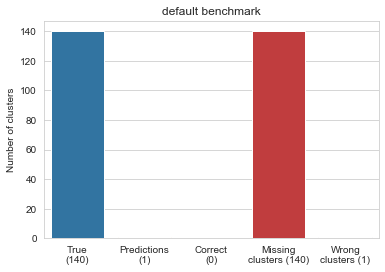

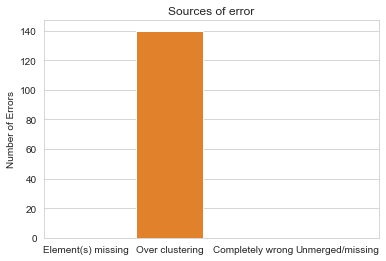

In [89]:
checkClust(mergeable_clusters=readout_clust(spectral_labels))

In [5]:
data = np.load('SPARSE_size_distorted.npy', allow_pickle=True)



In [14]:
rpc = []
for snp_input in data:
    cell_reads = 0
    for chrom in range(5):
        reads = np.argwhere(np.isnan(snp_input[chrom][:, 1]) == False).T[0]
        cell_reads += len(reads)
    rpc.append(cell_reads)

In [17]:
sum(rpc) * 2.5

5508800.0

In [70]:
rpc[358]

1239

In [71]:
rpc[1058]

2936

# Dimensionality reduction on data

## PCA dimensionality reduction:

I wonder how a PCA or dimensionality reduction technique will work as for as visualizing the data.

In [132]:
pca_fit = PCA(n_components=3).fit(p.T)

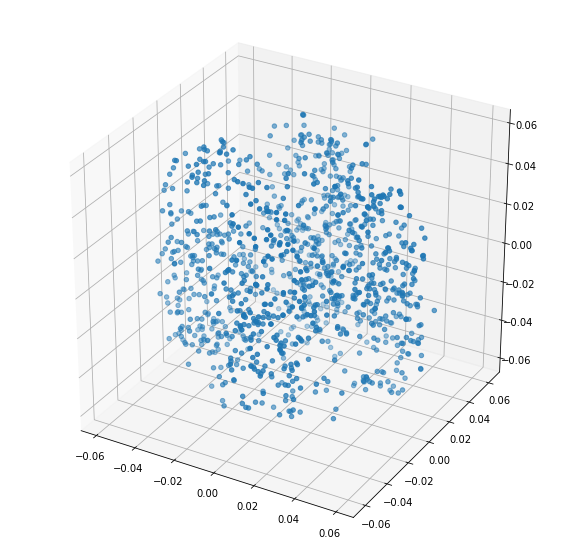

<function matplotlib.pyplot.close(fig=None)>

In [101]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(pca_fit.components_[0], pca_fit.components_[1], pca_fit.components_[2])
plt.show()
plt.close

In [116]:
pca_kmeans = KMeans(n_clusters=909).fit_predict(pca_fit.components_.T)

In [137]:
pca_ward = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.02, affinity='euclidean', linkage='ward').fit_predict(pca_fit.components_.T)

## PHATE dimensionality reduction

In [74]:
phate_cluster = phate.PHATE().fit(p)

Running PHATE on 1150 cells and 21577 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.25 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.19 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 1.47 seconds.


Calculating optimal t...


/home/iskander/anaconda3/lib/python3.7/site-packages/phate/plot.py:472: FutureWarning: `phate.plot.scatter3d` is deprecated. Use `scprep.plot.scatter3d` instead.
  FutureWarning)


  Automatically selected t = 37
Calculated optimal t in 0.41 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.18 seconds.
Calculating metric MDS...
Calculated metric MDS in 1.85 seconds.
Calculating metric MDS...
Calculated metric MDS in 4.10 seconds.


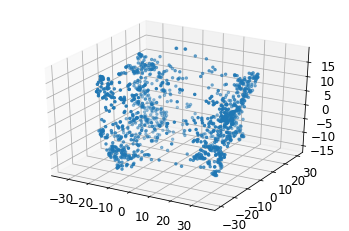

In [75]:
phate.plot.scatter3d(phate_cluster, cmap='Spectral')

In [76]:
phate_embeds = phate_cluster.embedding

kmeans = KMeans(n_clusters=909).fit_predict(phate_embeds)

In [85]:
start = time.time()
db_phate = DBSCAN(eps=1, min_samples=1).fit(phate_embeds)
end = time.time()
hours, rem = divmod(end - start, 3600)
minutes, seconds = divmod(rem, 60)
sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))

Time elapsed: 00:00:00.01


## tSNE dimension reduction

In [16]:
embed = TSNE(n_components=3).fit_transform(p)

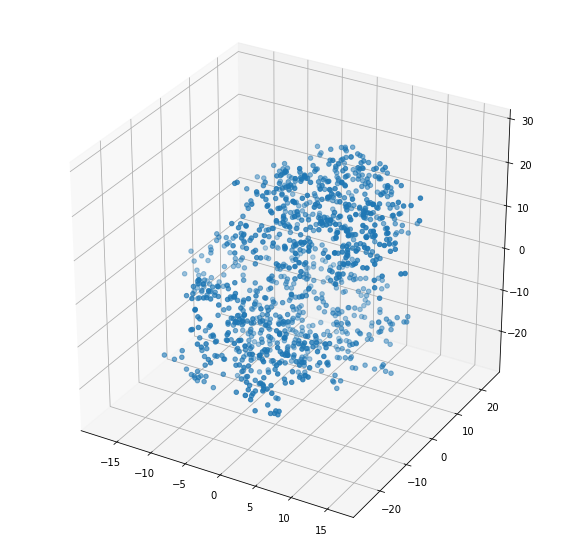

<function matplotlib.pyplot.close(fig=None)>

In [21]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(embed[:,0], embed[:,1], embed[:,2])
plt.show()
plt.close

# Algorithm parameter estimation

In order to determine the optimal parameters for a given clustering algorithm I am going to use the ARI statistic with our known data values and a Silhoutte model when we have unknown clusters.

## Ward agglomerative hierarchical 

In [25]:
ARI_ward = []
silh = []
d_params = []
for d in range(15, 45):
    hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=d, affinity='euclidean', linkage='ward')
    hierarchy_clusters = hierachy.fit_predict(p)
    rand_score, silhoutte = cluster_metrics(pred_labels=hierarchy_clusters, data=p)
    ARI_ward.append(rand_score)
    #silh.append(silhoutte)
    #d_params.append(d)
    

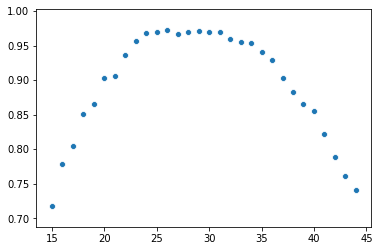

In [12]:
sns.scatterplot(d_params, ARI)
plt.show()
plt.close()

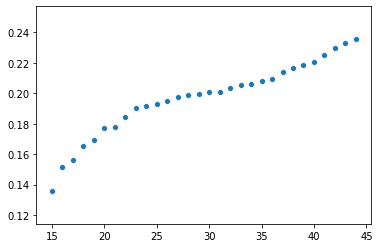

In [13]:
sns.scatterplot(d_params, silh)
plt.show()
plt.close()

The take home for this particular exploration of regime of parameters is that for a Agglomerative clustering the optimal parameter of D lies between 23-30 and 25 seems to be a good choice. 

Silhoutte score may not function well as a way to learn the cluster size in an unsupervised way. This is likely because our data and cluster space is not a typical clustering problem i.e. we have many sparse and noisy data points that do not fall within clusters, and clusters themselves are fairly sparse. 

As a follow up I am going to explore the same parameter space but for the DBSCAN algorithm.

## DBSCAN

In [19]:
ARI = []
silh = []
d_params = []
for d in range(15, 45):
    start = time.time()
    db_labels = DBSCAN(eps=d, min_samples=1).fit(p).labels_
    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    sys.stdout.write("Time elapsed: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours), int(minutes), seconds))
    rand_score, silhoutte = cluster_metrics(pred_labels=db_labels, data=p)
    ARI.append(rand_score)
    silh.append(silhoutte)
    d_params.append(d)

Time elapsed: 00:00:46.02
Time elapsed: 00:00:42.76
Time elapsed: 00:00:43.03
Time elapsed: 00:00:45.93
Time elapsed: 00:00:45.22
Time elapsed: 00:00:54.07
Time elapsed: 00:00:55.49
Time elapsed: 00:00:56.45
Time elapsed: 00:00:43.55
Time elapsed: 00:00:44.46
Time elapsed: 00:00:44.44
Time elapsed: 00:00:50.29
Time elapsed: 00:00:48.37
Time elapsed: 00:00:47.89
Time elapsed: 00:00:50.21
Time elapsed: 00:00:49.72
Time elapsed: 00:00:52.26
Time elapsed: 00:00:49.56
Time elapsed: 00:00:53.12
Time elapsed: 00:00:58.67
Time elapsed: 00:00:59.22
Time elapsed: 00:01:03.97
Time elapsed: 00:01:13.44
Time elapsed: 00:01:12.75
Time elapsed: 00:01:19.46
Time elapsed: 00:01:25.91
Time elapsed: 00:01:35.96
Time elapsed: 00:00:56.96
Time elapsed: 00:01:14.18
Time elapsed: 00:01:07.73


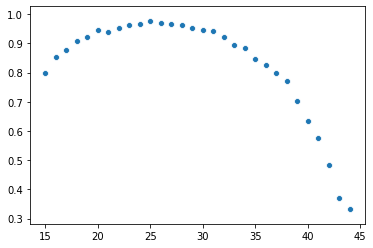

In [20]:
sns.scatterplot(d_params, ARI)
plt.show()
plt.close()

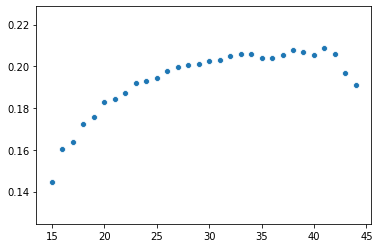

In [24]:
sns.scatterplot(d_params, silh)
plt.show()
plt.close()

The best ARI score for DBSCAN also seems to be at an eps=25 for this data set which mimics the Agglomerative distance parameter. The difference is that in the Agglomerative model the worst cases had a higher ARI than the worst cases in DBSCAN. If we plot these on the same axis we should be able to compare them more easily.

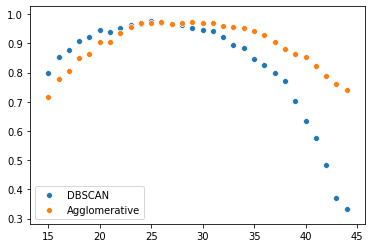

In [35]:
d_params = [x for x in range(15, 45)]
sns.scatterplot(d_params, ARI)
sns.scatterplot(d_params, ARI_ward)
plt.legend(['DBSCAN','Agglomerative'])
plt.show()
plt.close()

The conclusion I can draw from these ARI scores is that the ARI maximum is very similar in both models, but in the Agglomerative model the dropoff of ARI is much less severe. This makes me think that this model is actually better because it will tolerate errors in the distance parameter better. 

## Write-up on clustering algorithms

After attempting various different algorithms to determine which one performs the best under a dataset with known clusters I have determined that Hierarchical clustering under the Ward metric (d=25) and a DBSCAN algorithm (eps=25) work compareably well. DBSCAN seems to be marginally better. The sources of error seem to be primarily the same in either algorithm so is about 4x slower than Agglomerative but that difference is fairly small when it only takes about 10 seconds to cluster my data under Agglomerative and 40 seconds under DBSCAN.

After contemplating these various algorithms I think that Agglomerative is the best algorithm to use as was my initial suspicion, but now I have shown this more empirically. The ARI score on the Agglomerative model is pretty good and the distribution of ARIs across my distance parameter space and there is not an incredibly severe drop off of quality as I stray from the optimum. In other words I think the hierarchical clustering model is more resistant to incorrect parameter estimation and so will probably be my best bet for a clustering algorithm to use.

# Clustering test on simData v2:

New simulated data is much different than the previous data. The number of recombination breakpoints is sparser and consequently the number of E0s is higher. So I need re-optimize my clustering models to this new data set.

In [2]:
data = np.load('/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/SPARSE_test_DATA_simV2_HMM_posteriors.npy', allow_pickle=True)

In [3]:
H = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=10, affinity='euclidean', linkage='ward').fit_predict(data)
rand_score = cluster_metrics(pred_labels=H, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

NameError: name 'cluster_metrics' is not defined

In [22]:
scores = np.zeros(shape=(3, 30))
for d in range(1, 15):
    scores[0][d-1] = d
    #hierarchical
    hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=d, affinity='euclidean', linkage='ward')
    hierarchy_clusters = hierachy.fit_predict(data)
    rand_score, silhoutte = cluster_metrics(pred_labels=hierarchy_clusters, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
    scores[1][d-1] = rand_score
    
    #DBSCAN
    db_labels = DBSCAN(eps=d, min_samples=1).fit(data).labels_
    rand_score, silhoutte = cluster_metrics(pred_labels=db_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
    scores[2][d-1] = rand_score
    
    print('Iter {0} complete'.format(d-1))

Iter -14 complete
Iter -13 complete
Iter -12 complete
Iter -11 complete
Iter -10 complete
Iter -9 complete
Iter -8 complete
Iter -7 complete
Iter -6 complete
Iter -5 complete
Iter -4 complete
Iter -3 complete
Iter -2 complete
Iter -1 complete


I am now going to iterate through the parameter space that I have done previously. It'll probably end up taking a solid 20-30 minutes. Then I'll plot the rand_scores across the parameters and see if we can't find a new optima.

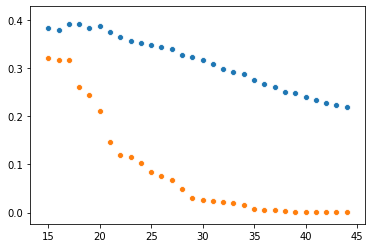

In [19]:
sns.scatterplot(scores[0,:], scores[1,:])
sns.scatterplot(scores[0,:], scores[2,:])

Okay, so this is looking not great. The optimum here is much, much worse. I no longer am able to capture nowhere near as much of the true labels. I'm going to try to run the parameters between d (1,15) to see if those parameters would work better than the (15, 45) d values. This is definetely not giving me hope in my method. What do I do if I find that the clustering is no longer working? Do I switch the metric by which I cluster by? Or should I try a different clustering algorithm?

[8.]


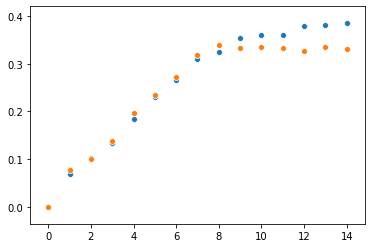

In [29]:

sns.scatterplot(scores[0,:], scores[1,:])
sns.scatterplot(scores[0,:], scores[2,:])
plt.show()
plt.close()

So, under the hierarchical model a .4 ARI seems to be the best I can do with an optimal distance parameter of 15. This is much worse than before. Previously a .9 ARI was easily achieved and now I am doing half as well as this. This is pretty disappointing. I'm going to run sciAnalysis with this optimal parameter in a seperate notebook and see what result I get. 

Alternatively, I could try different clustering algorithms to see if I get superior results. I am now starting to get worried that this method isn't going to work. Perhaps, I need to go back and think about what features I am clustering and see if I can 

## PHATE + cluster:

In [79]:
phate_cluster = phate.PHATE().fit(data)

Running PHATE on 1165 cells and 21577 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 16.52 seconds.
  Calculating KNN search...
  Calculated KNN search in 1.21 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 17.94 seconds.


Calculating optimal t...


/home/iskander/anaconda3/lib/python3.7/site-packages/phate/plot.py:472: FutureWarning: `phate.plot.scatter3d` is deprecated. Use `scprep.plot.scatter3d` instead.
  FutureWarning)


  Automatically selected t = 19
Calculated optimal t in 4.96 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.69 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.94 seconds.
Calculating metric MDS...
Calculated metric MDS in 12.53 seconds.


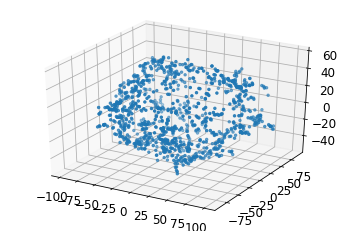

In [80]:
phate.plot.scatter3d(phate_cluster, cmap='Spectral')
plt.show()
plt.close()

In [81]:
phate_embeds = phate_cluster.embedding
k_labels = KMeans(n_clusters=971).fit_predict(phate_embeds)
rand_score = cluster_metrics(pred_labels=k_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.4215873853877361


So, as a lark I decided to use PHATE and then recluster my data to see if I couldn't improve the performance and it looks like I actually broke the .4 ARI barrier. I'm starting to think that using dimensionality reduction may be a good strat.

In [92]:
hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=2, affinity='euclidean', linkage='ward')
phate_hierarchy = hierachy.fit_predict(phate_embeds)
rand_score = cluster_metrics(pred_labels=phate_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.45229114778715696


Not much worse scores here I think I may be on to something.

In [96]:
db_labels = DBSCAN(eps=3, min_samples=1).fit(phate_embeds).labels_
rand_score = cluster_metrics(pred_labels=db_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.273368065739857


Well, this is an interesting turn of events. I'm not getting incredible results after using dimensionality reduction, but I am getting better results. I wonder if t-SNE will work better than PHATE.

## tSNE + cluster:

A consideration I must take is that tSNE initializes stochastically and so different seeds will yield different embeds. This could lead to different results with different random seeds. It is unclear to me if this will end up being a problem.

In [25]:
tsne_data = TSNE(n_components=3, perplexity=50, early_exaggeration=alpha, init='pca').fit_transform(data)

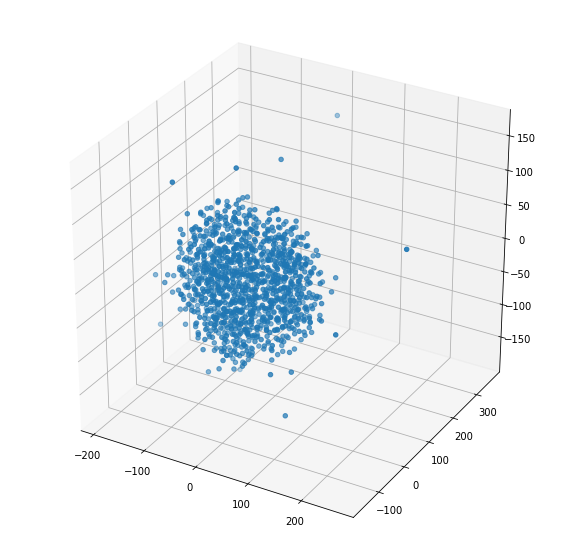

In [30]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(tsne_data[:,0], tsne_data[:,1], tsne_data[:,2])
plt.show()
plt.close()

In [ ]:
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.2, affinity='euclidean', linkage='ward').fit_predict(tsne_data)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

In [33]:
k_labels_t = KMeans(n_clusters=971).fit_predict(tsne_data)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.21908733835814564


Holy shit. Both of these scores are way better than PHATE and way better than simply clustering them outright. Let's check DBSCAN and see what happens.

In [32]:
db_labels_t = DBSCAN(eps=10, min_samples=1).fit(tsne_data).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.02457884371973931


I'm pretty happy with tSNE but I think for peace of mind I'll try PCA and see if that improves anything.

Try 2d tSNE + tricks:

In [22]:
alpha = len(data) / 3
tsne_2 = TSNE(n_components=2, perplexity=50, early_exaggeration=alpha, init='pca').fit_transform(data)

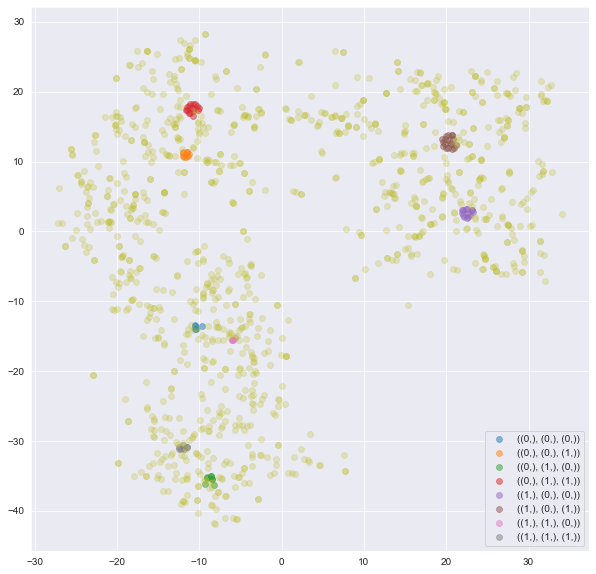

In [23]:
exclude = []
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(10,10))
    for key in E0_classes.keys():
        sns.scatterplot(tsne_2[E0_classes[key]][:,0], tsne_2[E0_classes[key]][:,1], edgecolor=None, alpha=.5)
        exclude = exclude + E0_classes[key]

    rest_x = np.delete(tsne_2[:,0], exclude)
    rest_y = np.delete(tsne_2[:,1], exclude)
    sns.scatterplot(rest_x, rest_y,alpha=.25, edgecolor=None) 
    leg = sorted(E0_classes.keys())
    plt.legend(leg)
    plt.show()
    plt.close()

In [28]:
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.1, affinity='euclidean', linkage='ward').fit_predict(tsne_2)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

db_labels_t = DBSCAN(eps=.1, min_samples=1).fit(tsne_2).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.660316232942063
0.6665626720025833


In [31]:
k_labels_t = KMeans(n_clusters=971).fit_predict(tsne_2)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.6665548502319802


In [36]:
gm_labels = GaussianMixture(n_components=970).fit_predict(tsne_2)
rand_score= cluster_metrics(pred_labels=gm_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.6665540379283063


In [244]:
#Implememnt HDBSCAN
hdb_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_method='leaf').fit(tsne_2).labels_
hdb_labels = deNoise(hdb_labels)
rand_score= cluster_metrics(pred_labels=hdb_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.32351082209497717


[(915, 1066, 1112), (243, 1097), (58, 1108), (691, 1117), (602, 1050), (207, 1077), (410, 1014), (350, 1053), (797, 1099), (95, 1118), (464, 1138), (847, 1142), (898, 1161), (559, 1120), (377, 1133), (473, 1165), (666, 1003), (529, 1145), (429, 1107), (528, 1137), (166, 996), (413, 988), (663, 1020), (485, 1113), (856, 984), (179, 1114, 1156), (190, 1087), (751, 978), (144, 1102), (137, 1146), (767, 1063), (820, 1089, 1144), (487, 998), (881, 991), (901, 986, 1017), (27, 1093), (412, 999), (92, 1030)]


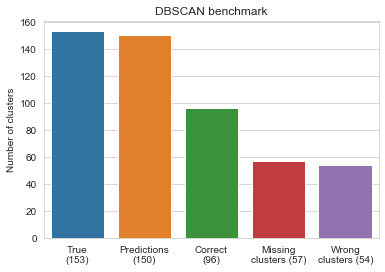

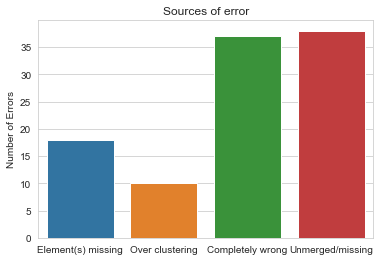

In [447]:
checkClust(mergeable_clusters=readout_clust(db_labels_t), model='DBSCAN')

[(915, 1066, 1112), (243, 1097), (58, 1108), (691, 1117), (207, 1077), (350, 1053), (797, 1099), (95, 1118), (464, 1138), (898, 1161), (559, 1120), (377, 1133), (473, 1165), (429, 1107), (528, 1137), (166, 996), (413, 988), (663, 1020), (485, 1113), (856, 984), (179, 1114, 1156), (190, 1087), (751, 978), (144, 1102), (137, 1146), (820, 1089, 1144), (487, 998), (881, 991), (901, 986, 1017), (27, 1093), (92, 1030)]


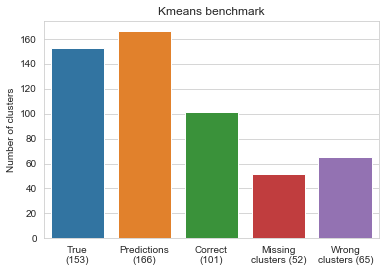

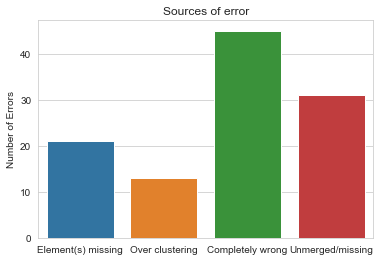

In [454]:
checkClust(mergeable_clusters=readout_clust(k_labels_t), model='Kmeans')

Gaussian mixture seems to work super well without any parameter inputs which I really like. And a 2d tSNE is quite faster than 3d and seems to give better results than implementing PCA initial dimension reduction. I want to see how much of our low score is due to the E0s so I'm going to filter them out of the embedding rather than recomputing the embedding without the E0s.

In [439]:
filtered_tsne_2 = np.delete(tsne_2, exclude, axis=0)
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.1, affinity='euclidean', linkage='ward').fit_predict(filtered_tsne_2)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

db_labels_t = DBSCAN(eps=.1, min_samples=1).fit(filtered_tsne_2).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

k_labels_t = KMeans(n_clusters=920).fit_predict(filtered_tsne_2)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

gm_labels = GaussianMixture().fit_predict(filtered_tsne_2)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude = exclude)
print(rand_score)

#Implememnt HDBSCAN
hdb_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_method='leaf').fit(filtered_tsne_2).labels_
hdb_labels = deNoise(hdb_labels)
rand_score= cluster_metrics(pred_labels=hdb_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.7204920295676828
0.7415352913312846
0.7089459825838722
0.7089459825838722
0.3226326828199783


The quality of labelling increased by ~.05 which I think is prety good. Clearly the clustering by itself is not working extremely well under the given low coverage. And this actually seems to cluster better than the 21k dimensions with E0s excluded. There could simply be issues with low coverage that I can't get around. 

In [419]:
alpha= len(data)/3
filtered_tsne_2 = TSNE(n_components=2, perplexity=50, early_exaggeration=alpha, init='pca').fit_transform(filtered_data)

0.693364958993941
0.7127735930292931
0.6979170547377048
0.6979170547377048
0.3389966236194381


In [433]:
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.2, affinity='euclidean', linkage='ward').fit_predict(filtered_tsne_2)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

db_labels_t = DBSCAN(eps=.15, min_samples=1).fit(filtered_tsne_2).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.7084777227877257
0.7218676266715992


In [434]:
k_labels_t = KMeans(n_clusters=920).fit_predict(filtered_tsne_2)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

gm_labels = GaussianMixture().fit_predict(filtered_tsne_2)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude = exclude)
print(rand_score)

#Implememnt HDBSCAN
hdb_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_method='leaf').fit(filtered_tsne_2).labels_
hdb_labels = deNoise(hdb_labels)
rand_score= cluster_metrics(pred_labels=hdb_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.6929648753071754
0.6929648753071754
0.3389966236194381


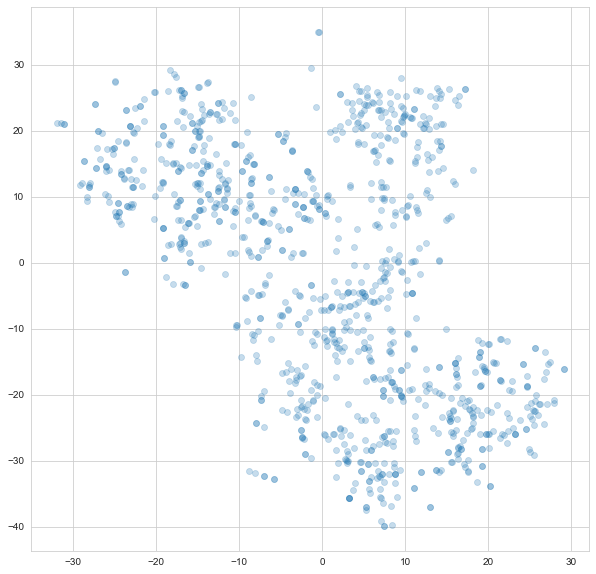

In [435]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10,10))
    sns.scatterplot(filtered_tsne_2[:,0], filtered_tsne_2[:,1], edgecolor=None, alpha=.25)
    plt.show()
    plt.close()

Including E0s in the data when clustering seems to negatively impact my ARI scores as would be predicted. But removing them before or after I do manifold reduction seems to be not as important. There seems to be some benefit to including the E0s when doing manifold learning. Also a larger early exaggeration seems to be very beenificial for clustering these data.

## PCA + cluster:

In [20]:
pca_fit = PCA(n_components=3).fit(data.T)

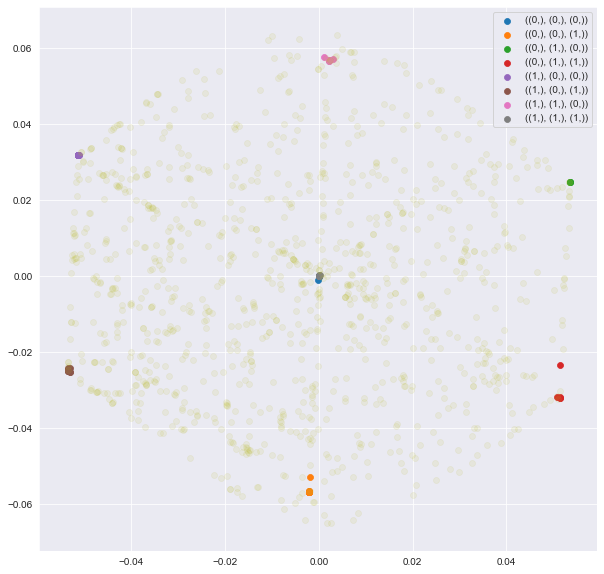

In [21]:
exclude = []

with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(10,10))
    for key in sorted(E0_classes.keys()):
        sns.scatterplot(pca_fit.components_.T[E0_classes[key]][:,0], pca_fit.components_.T[E0_classes[key]][:,1], edgecolor=None, alpha=1)
        exclude = exclude + E0_classes[key]
    leg = sorted(E0_classes.keys())
    rest_x = np.delete(pca_fit.components_.T[:,0], exclude)
    rest_y = np.delete(pca_fit.components_.T[:,1], exclude)
    sns.scatterplot(rest_x, rest_y,alpha=.1, edgecolor=None) 
    plt.legend(leg)
    plt.show()
    plt.close()

In [315]:
hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.003, affinity='euclidean', linkage='ward')
pca_hier = hierachy.fit_predict(pca_fit.components_.T)
rand_score = cluster_metrics(pred_labels=pca_hier, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.31973678625389435


In [316]:
k_labels_pca = KMeans(n_clusters=971).fit_predict(pca_fit.components_.T)
rand_score= cluster_metrics(pred_labels=k_labels_pca, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.2763748691250398


In [317]:
db = DBSCAN(eps=.003, min_samples=1).fit_predict(pca_fit.components_.T)
rand_score= cluster_metrics(pred_labels=db, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.2245196351883827


## PCA + tSNE + cluster

In the sklearn tSNE manual it made a suggestion to reduce the dimension first with PCA and then feed it into tSNE as it could improve the results. I am willing to give this a shot as well.

In [4]:
def extrStates(states):
    #I am attempting to conform the reading of these known labels to the way that I have produced the HMM labels
    #within sciAnalysis so I can re-use code....
    state_tuples = []
    if len(states) > 1:
        for s in range(len(states)-1):
            state_tuples.append((states[s], states[s+1]))
    else:
        state_tuples.append(states[0])
    
    return state_tuples

def readCO(tsv, path, sample_num=960):
    #Record only the individuals that are unique the sampling to get the true AF
    COs = []
    labels = []
    add_Mb = {'2L': 0, '2R': 23000000, '3L': 0, '3R': 24500000, 'X': 0}
    full_tsv = os.path.join(path, tsv)
    with open(full_tsv, 'r') as myTsv:
        TSV_reader = csv.reader(myTsv, delimiter='\t')

        index = 0
        for field in TSV_reader:
            #each individual will have an array of their breakpoints and their chromosome states
            chr2 = [int(pos)/1000000 for pos in field[2].split(',') if pos != ''] + [(int(pos) + add_Mb['2R'])/1000000 for pos in field[5].split(',') if pos != '']
            chr2_states = [int(segment) for segment in field[3].split(',')][:-1] + [int(segment) for segment in field[6].split(',')]
            refChr2 = extrStates(states=chr2_states)
            
            chr3 = [int(pos)/1000000 for pos in field[8].split(',') if pos != ''] + [(int(pos) + add_Mb['3R'] )/1000000for pos in field[11].split(',') if pos != '']
            chr3_states = [int(segment) for segment in field[9].split(',')][:-1] + [int(segment) for segment in field[12].split(',')]
            refChr3 = extrStates(states= chr3_states)
            
            chrx = [int(pos)/1000000 for pos in field[14].split(',') if pos != '']
            chrx_states = [int(segment) for segment in field[15].split(',')]
            refChrx = extrStates(states=chrx_states)
            
            all_labels = [refChr2, refChr3, refChrx]
            all_COS = [chr2, chr3, chrx]
            COs.append(all_COS)
            labels.append(all_labels)
            
            if index == sample_num-1:
                break
            index += 1
            
    return COs, labels


In [5]:
COs, labels = readCO(tsv='test_DATA_simV2_crossovers.tsv', path='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/', sample_num=1165)

In [6]:
#Create matrix of number of recombination breakpoints per individual
CO_vect = np.zeros(shape=len(COs)) 
for bcs in range(len(COs)):
    total_E = 0
    for bp in range(3):
        total_E += len(COs[bcs][bp])      
    CO_vect[bcs] = total_E

print(len(COs))
#Calculated the frequency of the E0s
E0_freq = len(np.where(CO_vect == 0)[0]) / len(COs)
print(E0_freq)
#Now I want to check the labels to see if there are any non-unique E0s meaning any E0s with the same set of gametes
E0s = np.where(CO_vect == 0)
E0_labels = []
for f in E0s[0]:
    E0_labels.append((labels[f][0][0], labels[f][1][0], labels[f][2][0]))

non_uniq_E0 = len(E0_labels) - len(set(E0_labels))
non_uniq_E0_freq = non_uniq_E0 / len(COs)
print(non_uniq_E0_freq)

#Get create cluster labels for E0s of each of the 8 possible classes
E0_classes = {}
for i in np.where(CO_vect == 0)[0]:
    hashable_label = tuple([tuple(state) for state in labels[i]])
    if hashable_label not in E0_classes.keys():
        E0_classes[hashable_label] = [i]

    else:
        E0_classes[hashable_label].append(i)


1165
0.06866952789699571
0.061802575107296136


In [14]:
pca_fit = PCA(n_components=50).fit(data.T)

In [15]:
#Define early exaggeration paramters according to https://arxiv.org/pdf/1706.02582.pdf

alpha = len(data) / 10
print(alpha)

116.5


In [16]:
tsne_2d = TSNE(n_components=2, perplexity=25, early_exaggeration=alpha, init='pca').fit(pca_fit.components_.T)
embedding = tsne_2d.embedding_

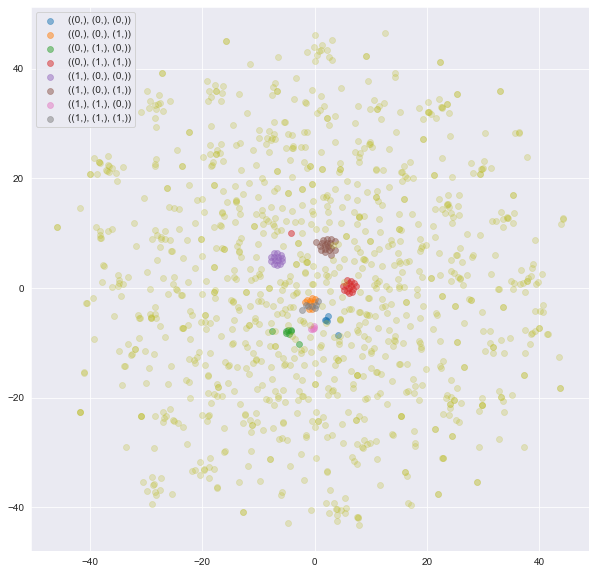

In [17]:
exclude = []
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(10,10))
    for key in E0_classes.keys():
        sns.scatterplot(embedding[E0_classes[key]][:,0], embedding[E0_classes[key]][:,1], edgecolor=None, alpha=.5)
        exclude = exclude + E0_classes[key]

    rest_x = np.delete(embedding[:,0], exclude)
    rest_y = np.delete(embedding[:,1], exclude)
    sns.scatterplot(rest_x, rest_y,alpha=.25, edgecolor=None)  
    leg = sorted(E0_classes.keys())
    plt.legend(leg)
    plt.show()
    plt.close()

So I suspected that the largest clusters would be the E0s and we can clearly see that this is the case. But there are also some of the E0s that should be within the cluster that are not and some other individuals that cluster together, but shouldnt. I think a way to optimize my clustering would be to see how well this 2d manifold structures these E0 clusters.

I reduce the number of dimension first with PCA to 50 and then used tSNE to learn the manifold into three components. The output of this looks very very strange. I get a large clump in the center and small dots out in  the periphery.

In [474]:
db_labels_t = DBSCAN(eps=.1, min_samples=1).fit(embedding).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.5414392068385967


In [470]:
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold= .1                                       , affinity='euclidean', linkage='ward').fit_predict(embedding)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.5243558424926661


In [392]:
k_labels_t = KMeans(n_clusters=971).fit_predict(embedding)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.5963558713334498


In [394]:
gm_labels = GaussianMixture().fit_predict(embedding)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.5963558713334498


In [10]:
def deNoise(label):
    noise = np.where(label == -1)
    replacement = np.asarray([i + max(label) for  i in range(len(noise[0]))])
    label[noise] = replacement
    return label

In [108]:
#Implememnt HDBSCAN
hdb_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_method='leaf').fit(embedding).labels_
hdb_labels = deNoise(hdb_labels)
rand_score= cluster_metrics(pred_labels=hdb_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.23030679453377867


Playing with the perplexity to lower values and reducing input dimensions doesn't necessarily improve my labelling from just straight up tSNE, but it does improve the speed. My ARI for the hierarchical clustering seems to be pretty solid ~.62. That is less than what I was getting when performing tSNE by itself, but the speed increase is really nice. I have found that a solid middle ground between speed and quality is to reduce components via PCA and then tSNE cluster in 2d and use a large early exaggeration parameter. This seems to work  pretty well. DBSCAN, hierarchy and Kmeans both work very well. HDBSCAN doesn't seem to be a good clustering method for these data.

One thing that I am curious about is how much of my error in clustering is due to the fact that my E0s cluster together. To get to this I'll just remove them from my data frame and then run my PCA/tSNE manifold reduction.


In [18]:
# No E0s clustering checks:
filtered_data = np.copy(data)
filtered_data = np.delete(filtered_data, exclude, axis=0)
pca_filt = PCA(n_components=50).fit(filtered_data.T)
tsne_filt = TSNE(n_components=2, perplexity=25, early_exaggeration=alpha, init='pca').fit(pca_filt.components_.T)
embed_filt = tsne_filt.embedding_

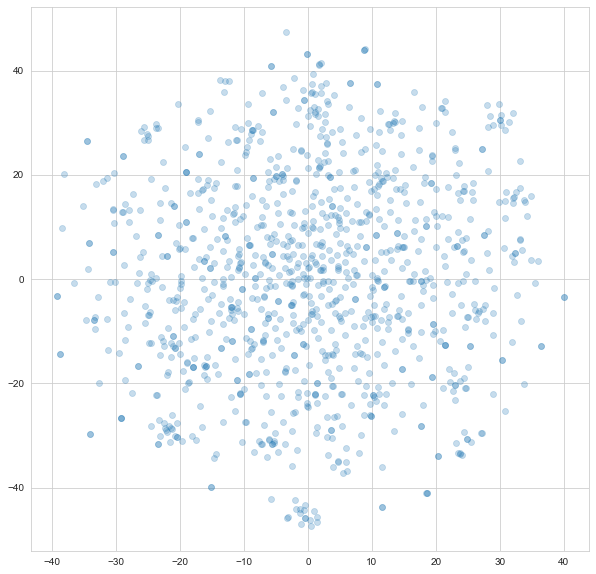

In [221]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(10,10))
    sns.scatterplot(embed_filt[:,0], embed_filt[:,1], edgecolor=None, alpha=.25)
    plt.show()
    plt.close()

In [229]:
db_labels_t = DBSCAN(eps=.5, min_samples=1).fit(embed_filt).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold= .5, affinity='euclidean', linkage='ward').fit_predict(embed_filt)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)


0.6225258673026921
0.604704320853981


In [180]:
k_labels_t = KMeans(n_clusters=920).fit_predict(embed_filt)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.6681778058519252


Filtering the E0s before dimension reduction doesn't seem to increase my ARI significantly. But what about removing them after dimensionality reduction?

## E0s filtered No dimension reduction:

Here's a thought. How well does my data cluster when I get rid of E0s and do not dimensionality reduction?

In [19]:
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold= 15, affinity='euclidean', linkage='ward').fit_predict(filtered_data)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.7050934428668342


In [9]:
#No filtering of E0s so I can compare the two processes
tsne_hierarchy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold= 10, affinity='euclidean', linkage='ward').fit_predict(data)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.35530671309695255


In [138]:
db_labels_t = DBSCAN(eps=15, min_samples=1).fit(filtered_data).labels_
rand_score = cluster_metrics(pred_labels=db_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv', exclude=exclude)
print(rand_score)

0.6232697998679984


In [167]:
#Implememnt HDBSCAN
hdb_labels = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, cluster_selection_method='eom').fit(filtered_data).labels_
hdb_labels = deNoise(hdb_labels)
rand_score= cluster_metrics(pred_labels=hdb_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv',exclude=exclude)
print(rand_score)

0.3858099247796691


Removing E0s before clustering gives me effectively the same ARI score as I would have if I did not filter. This means that even though I have E0s that are mesing with my cluster labelling there are other problems in the data that are messing with my labelling. I will say that hierarchical does give .7 ARI which is quite nice. The problem is that even without E0s it still doesn't cluster at the level that it was before. This is probably because the recombination rate is lower and so there is less discrete changes between states. I wonder if switching back to recombination breakpoints would be better?

It would be possible to filter E0s before doing posterior prob predictions by just running viterbi and get all individuals where no breakpoints were predicted on all arms.  

## UMAP + cluster

UMAPS is a method I had neglected to look at and so now I will try it out and see what results I get.

In [3]:
import umap

In [380]:
umap_embed = umap_.UMAP(n_neighbors=5, n_components=2, min_dist=0.5).fit_transform(data)

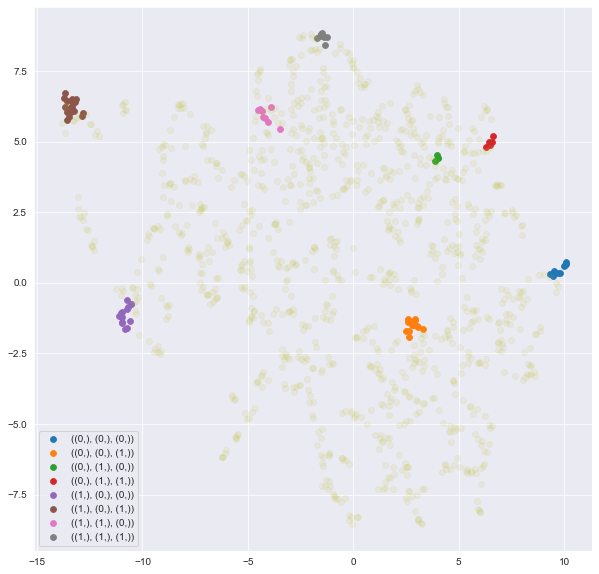

In [381]:
exclude = []

with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(10,10))
    for key in sorted(E0_classes.keys()):
        sns.scatterplot(umap_embed[E0_classes[key]][:,0], umap_embed[E0_classes[key]][:,1], edgecolor=None, alpha=1)
        exclude = exclude + E0_classes[key]
    leg = sorted(E0_classes.keys())
    rest_x = np.delete(umap_embed[:,0], exclude)
    rest_y = np.delete(umap_embed[:,1], exclude)
    sns.scatterplot(rest_x, rest_y,alpha=.1, edgecolor=None) 
    plt.legend(leg)
    plt.show()
    plt.close()

This embedding performs very fast. Much faster than tSNE and it is a deterministic function which is useful.

In [383]:
db_labels_U = DBSCAN(eps=1, min_samples=1).fit(umap_embed).labels_
rand_score = cluster_metrics(pred_labels=db_labels_U, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

6.42720309923807e-05


In [348]:
umap_hier = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.002, affinity='euclidean', linkage='ward').fit_predict(umap_embed)
rand_score = cluster_metrics(pred_labels=umap_hier, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.31113350696930686


In [370]:
k_labels_U = KMeans(n_clusters=971).fit_predict(umap_embed)
rand_score= cluster_metrics(pred_labels=k_labels_U, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.23956701878062198


Over all the UMAP embedding and clustering on the reduced dimensions seems to behave much worse on my training set than simply using tSNE and then clustering off of that data. UMAP generally is worse than the tSNE method. 

## Spectral clustering:

Because I have been having a hard time implementing the spectral clustering library I'm going to try to precompute the affinity matrix by using spectral embedding library and then perform a kmeans clustering on the spectral embedding.

In [27]:
spect_embed = SpectralEmbedding().fit(data)

In [33]:
spect_k = KMeans(n_clusters=971).fit(spect_embed.embedding_).labels_

In [34]:
rand_score = cluster_metrics(pred_labels=spect_k, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.20314874130925795


In [36]:
aff_matrix = SpectralEmbedding().fit(embedding).affinity_matrix_
sc_labels = SpectralClustering(n_clusters=971, affinity='precomputed').fit(aff_matrix).labels_
rand_score = cluster_metrics(pred_labels=sc_labels, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.0076565449270956055


# Benchmarking:

Benchmarking this method is going to require several levels of optimization. We must choose an optimal clustering algorithm, infer optimal parameters for that algorithm, and also infer optimal parameters for our tSNE algorithm. All of these things are important and will play a role in how good our method ends up being at calling clusters.

In [213]:
tsne_data = TSNE(n_components=3, perplexity=5).fit_transform(data)

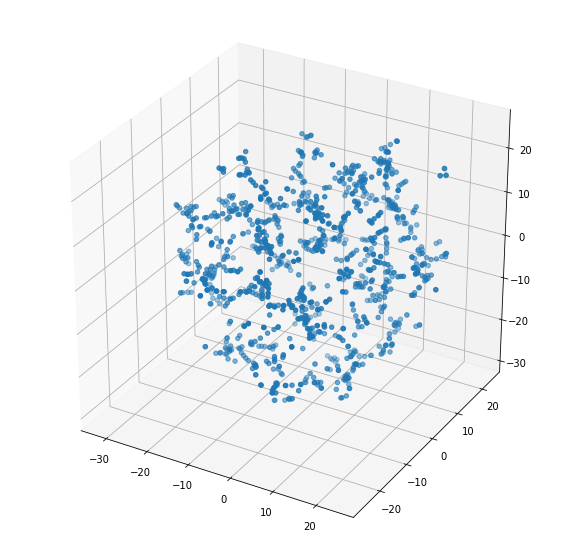

In [214]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(tsne_data[:,0], tsne_data[:,1], tsne_data[:,2])
plt.show()
plt.close()

In [215]:
k_labels_t = KMeans(n_clusters=971).fit_predict(tsne_data)
rand_score= cluster_metrics(pred_labels=k_labels_t, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.543232818684589


In [216]:
hierachy = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=.2, affinity='euclidean', linkage='ward')
tsne_hierarchy = hierachy.fit_predict(tsne_data)
rand_score = cluster_metrics(pred_labels=tsne_hierarchy, data=data, truth_tsv='/home/iskander/Documents/Barbash_lab/mDrive/SIM_DATA/test_DATA_simV2_crossovers.tsv')
print(rand_score)

0.5198640383100387


Okay, so because initializing all of these tSNEs takes quite some time I'm going to create a small function to wrap everything and then write it up into a small script to submit to the cluster.

In [7]:
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn import metrics
import numpy as np
from sklearn.cluster import KMeans 

def cluster_metrics(pred_labels, truth_tsv, data, exclude=False):
    """
    This method will calculate some clustering metrics to quantify the classifier
    """
    true_labels = []
    with open(truth_tsv, 'r') as Check:
        reader = csv.reader(Check, delimiter='\t')
        
        for field in reader:
            true_labels.append(int(field[0]))
    if exclude != False:
        true_labels = np.delete(np.asarray(true_labels), exclude)
    rand_score = metrics.adjusted_rand_score(true_labels, pred_labels)
    
    return rand_score

def optClustering(perplex, data, TSV_path, D=40):
    
    """
    Perform optimization of clustering algorithm and tSNE manifold reduction
    """
    #Initialize data manifold
    tsne_data = TSNE(n_components=3, perplexity=perplex).fit_transform(data)
    
    
    hierachical_ARI_vect = np.zeros(shape=D)
    db_ARI_vect = np.zeros(shape=D)
    #Iterate through the eps and distance parameters for hierachy and DBSCAN respectively:
    for d in range(D):
        param = (d + 1) / 100
        hierachy_labels = AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold = param, affinity='euclidean', linkage='ward').fit_predict(tsne_data)
        db_labels = DBSCAN(eps= param, min_samples=1).fit(tsne_data).labels_
        ARI_hierarch = cluster_metrics(pred_labels=hierachy_labels, data=data, truth_tsv=TSV_path)
        ARI_db = cluster_metrics(pred_labels=db_labels, data=data, truth_tsv=TSV_path)
        hierachical_ARI_vect[d] = ARI_hierarch
        db_ARI_vect[d] = ARI_db
    
    #Iterate through k-means optimizations
    kmeans_ARI_vect = np.zeros(shape=D)
    i = 0 
    for K in range(850, 1051, 10):
        kmeans_labels = KMeans(n_clusters=K, n_jobs=10).fit_predict(tsne_data)
        kmeans_ARI = cluster_metrics(pred_labels=kmeans_labels, data=data, truth_tsv=TSV_path)
        kmeans_ARI_vect[i] = kmeans_ARI
        i += 1
    
    return kmeans_ARI_vect, hierachical_ARI_vect, db_ARI_vect

def main():
    K_matrix = np.zeros(shape=(4, 21))
    DB_matrix = np.zeros(shape=(4, 40))
    hier_matrix = np.zeros(shape=(4, 40))
    perplex_values = [5, 15, 30, 50]
    posterior_data = np.load('SPARSE_test_DATA_simV2_HMM_posteriors.npy', allow_pickle=True)
    true_labels = 'test_DATA_simV2_crossovers.tsv'
    i = 0
    for p in perplex_values:
        KM, H, DB = optClustering(perplex=p, data=posterior_data, TSV_path=true_labels)
        K_matrix[i] = KM
        DB_matrix[i] = DB
        hier_matrix[i] = H
        i += 1


In [268]:
uniq = []

for i in range(10000):
    noisy_cells = np.random.randint(low=48*20, high = (48*25) + 1 )
    uniq.append(len(set(np.random.choice(a=4000, size=noisy_cells))))

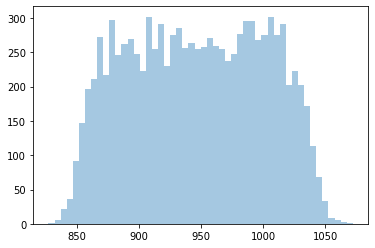

In [271]:
sns.distplot(uniq, kde=False, bins=50)
plt.show()
plt.close()

A range of k-values are derived from the distribution above.

I ran the script defined above on the cluster and have obtained ARI scores for different parameter spaces I will now do some performance benchmarking.

In [137]:
hierarchical_ARI = np.load('hier_ARI.npy')
db_ARI = np.load('DB_ARI.npy')
k_ARI = np.load('K_ARI.npy')
hierarchical_ARI_r2 = np.load('hier_ARI_r2.npy')
db_ARI_r2 = np.load('DB_ARI_r2.npy')
k_ARI_r2 = np.load('K_ARI_r2.npy')

In [138]:
d_params = [d/100 for d in range(40)]
k_params = [k for k in range(850, 1051, 10)]
d_params_2 = [d/100 for d in range(100)]
k_params_2 = [k for k in range(850, 1051, 5)]

In [144]:
def plot_ARI(x, ARIs, title, p = ['Perplex = 5', 'Perplex = 15', 'Perplex = 30', 'Perplex = 50']):
    for i in range(4):
        sns.scatterplot(x, ARIs[i,:], alpha=.5, edgecolor=None)
    
    plt.ylabel('ARI')
    plt.xlabel('Parameter')
    plt.legend(p)
    plt.title(title)
    plt.show()
    plt.close()

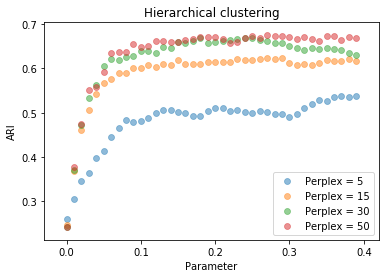

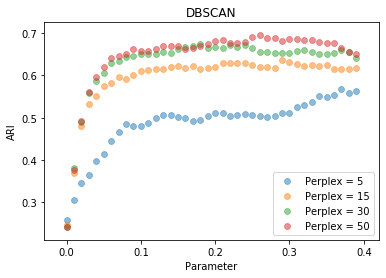

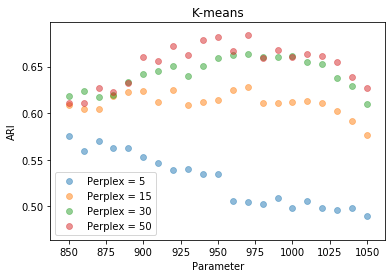

In [145]:
plot_ARI(d_params, hierarchical_ARI, title='Hierarchical clustering')
plot_ARI(d_params, db_ARI, title='DBSCAN')
plot_ARI(k_params, k_ARI, title='K-means')

It seems that a perplexity of 50 seems to be the optimal performance parameter on this data set although 30-50 seem to be reasonable initializations. K-means seems to perform over all a little bit worse and sees to be more sensitive to perturbations in the k parameter.

I'm going to see how DBSCAN and hierarchcial clustering compare when perplexity = 50.

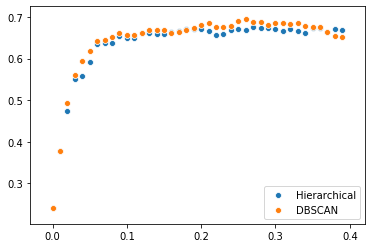

In [41]:
sns.scatterplot(d_params, hierarchical_ARI[3,:])
sns.scatterplot(d_params, db_ARI[3,:])
leg = ['Hierarchical', 'DBSCAN']
plt.title()
plt.legend(leg)
plt.show()
plt.close()

So DBSCAN is now outperforming hierarchical clustering and both seem to have fairly tolerable parameters. I am going to run the parameter space from .4-1 to see how the drop off in quality of the methods.

K-means clustering also seems to perform very well under perplexity of 50. I can't directly plot them on the same axis as the k parameter is not the same scale as the distance and eps parameter are, but I can pull out some maximum values and compare them.

In [54]:
print(max(k_ARI[3,:]))
print(max(db_ARI[3,:]))
print(max(hierarchical_ARI[3,:]))

0.683989120912447
0.6949905178316199
0.6751575429533885


DBSCAN seems to have the biggest maximum ARI, but not by much. 

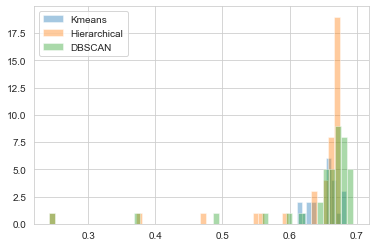

In [154]:
with sns.axes_style('whitegrid'):
    sns.distplot(k_ARI[3,:], bins=10, kde=False)
    sns.distplot(hierarchical_ARI[3,:], bins=50, kde=False)
    sns.distplot(db_ARI[3,:], bins=50, kde=False)
    plt.legend(['Kmeans', 'Hierarchical', 'DBSCAN'])
    plt.show()
    plt.close()

If we compare the distributions of these three methods we can see that although the heights are different because there differring number of parameters run for k-means and for the others the ARI density in DBSCAN seems to be more heavily shifted to the right ie better. And although for k-means I was running under a regime of expected optimal parameters they still don't behave better than DBSCAN. DBSCAN over all seems to perform the best when I use tSNE manifold learning on the data. And the optimal parameter seems to be ~.25. 

I'm going to generate a larger simulated data set to see if my optimal parameters maintain their ability to perform well. My intuitition is that it should work reasonably well.

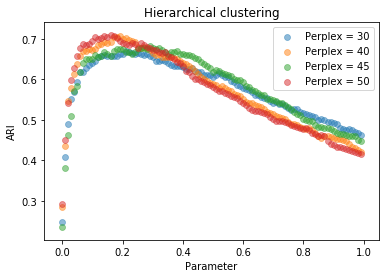

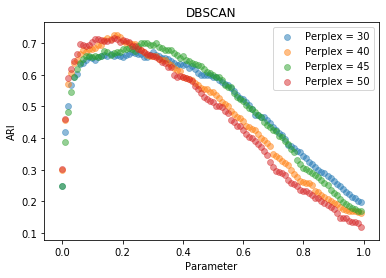

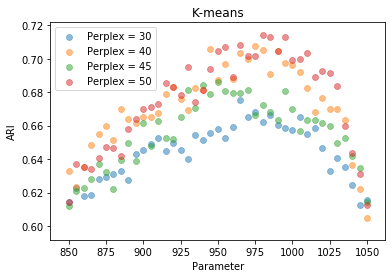

In [146]:
perp = ['Perplex = 30', 'Perplex = 40', 'Perplex = 45', 'Perplex = 50']
plot_ARI(d_params_2, hierarchical_ARI_r2, title='Hierarchical clustering', p=perp)
plot_ARI(d_params_2, db_ARI_r2, title='DBSCAN', p=perp)
plot_ARI(k_params_2, k_ARI_r2, title='K-means',p=perp)

In [165]:
print(max(k_ARI_r2[3,:]))
print(max(db_ARI_r2[3,:]))
print(max(hierarchical_ARI_r2[3,:]))

0.7141917738927002
0.7147948118382603
0.7094381322269847


A more exhaustive implementation of parameter space and of perplexity initializations show me that the relationship of perplexity to ARI is not strictly monotonic. There seems to be certainly be a degree of stochasticity with the initialization, but a general relationship seems to imply that high perplexity is better for my dataset. I have some worry that larger datasets will require different optimizations of perplexity. 

I spent quite some time implementing various other techniques after I did this optimization and I found that using PCA to reduce the dimension to 50 and then 2d tSNE reduction w/ the "early exaggeration" trick seems to work almost as well as pure tSNE, but it converges much quicker. I find that using a 2d embedding in general is way better than 3d embeding. Also Gaussian Mixture clustering is a pretty sweet approach too. I may try it more on this reduced data. Plus it gives me an AIC/BIC criterion which I could use to quantify how good my clustering performs.

All of the tSNE approaches I see implement PCA reduction before inputting into tSNE, and although this does increase performence it doesn't really perform better and it actually kind of looks worse graphically.